<a href="https://colab.research.google.com/github/george-kan/fastai/blob/main/Chapter14/Chapter_14_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade fastai
from fastai.vision.all import *
from fastai import *

     |████████████████████████████████| 194kB 5.6MB/s 
     |████████████████████████████████| 12.8MB 215kB/s 
     |████████████████████████████████| 776.8MB 22kB/s 
     |████████████████████████████████| 61kB 8.2MB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.0+cu101
    Uninstalling torch-1.8.0+cu101:
      Successfully uninstalled torch-1.8.0+cu101
  Found existing installation: torchvision 0.9.0+cu101
    Uninstalling torchvision-0.9.0+cu101:
      Successfully uninstalled torchvision-0.9.0+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


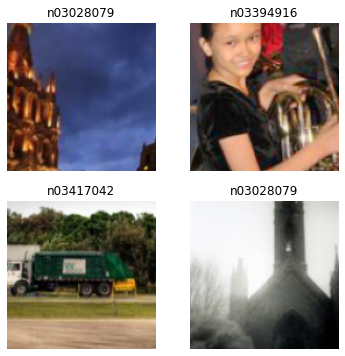

In [2]:
def get_data(url, presize, resize):
    path = untar_data(url)
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock), get_items=get_image_files,
        splitter=GrandparentSplitter(valid_name = 'val'),
        get_y=parent_label, item_tfms=Resize(presize),
        batch_tfms=[*aug_transforms(min_scale=0.5, size=resize), Normalize.from_stats(*imagenet_stats)]
    ).dataloaders(path, bs = 128)

dls = get_data(URLs.IMAGENETTE_160, 160, 128)
dls.show_batch(max_n = 4)

In [3]:
def avg_pool(x): return x.mean((2,3))

In [18]:
temp = torch.tensor([[1,2], [3,4]]).float()
temp2 = temp.unsqueeze(0).unsqueeze(0)
avg_pool(temp2).shape

torch.Size([1, 1])

In [23]:
nn.AdaptiveAvgPool2d(1)(temp2).shape

torch.Size([1, 1, 1, 1])

In [34]:
nn.AdaptiveAvgPool2d(1)(torch.ones(2,2,2,2,2)).shape

torch.Size([2, 2, 2, 1, 1])

nn.AdaptiveAvgPool2d(1) does the same as the avg_pool function (but with more flexibility): It returns the mean of the last two dimensions of the tensor.

In [39]:
nn.Flatten()(torch.ones(2,2,2,2,2)).shape

torch.Size([2, 16])

nn.Flatten takes a tensor of dimensions x,y,z,w and returns a tensor of dimensions x,y*z*w

In [ ]:
def block(ni, nf): return ConvLayer(ni, nf, stride = 2)
def get_model():
    return nn.Sequential(
        block(3, 16),
        block(16, 32),
        block(32, 64),
        block(64, 128),
        block(128, 256),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(256, dls.c)
    )

Let's have a look at the model:  
We start with an arbitrary input size but we need 3 channels. At every layer due to the stride we increase the channels but what gets smaller is the input size for these channels.  
The input to the adaptiveavgpool2d layer is 256, x, y, z and the output will be 256, x, 1, 1.  
After the Flatten layer we will have 256 which will go into the Linear layer and output the categories of the dataloader (dls.c)

In [19]:
??nn.AdaptiveAvgPool2d